### Introduction to Naive Bayes

The Naive Bayes classification machine learning model uses Bayes Theorem to classify data points into one of several labels. When multiple features are used, the model calculates the probability of each label being the true label based on the conditional probability from the state of the feature. This is done for each of the features present, and the model assigns the label with the highest probability.

The Naive Bayes model operates under the assumption that the effects of the different features are independent of one another.

Given my prior hypothesis that certain team evaluation metrics during powerplays may be more predictive of regular season team success, I am looking to use Naive Bayes classification to determine which features are most predictive and then determine if these features during power play situations can be more accurately used to train a ML model to predict playoff berths then features from regular 5 on 5 game play.

### Prepare Data for Naive Bayes

I prepared the team powerplay data for Naive Bayes classification in an R file linked here. Team data from the 2018-2019, 2020-2021, 2021-2022, and 2022-2023 seasons were combined and the desired features were subsetted from the greater dataset. An additional variable was added for whether or not the team made the playoffs that season and all numerical metrics were normalized. Finally, all non-numerical variables except the playoff variable were removed.

In [83]:
import numpy as np
import pandas as pd

In [84]:
df=pd.read_csv("../data/01-modified-data/team_pp_data_clean.csv")
print(df.shape)

label = df['playoff'].copy()
df=df.drop(columns=['Unnamed: 0','playoff'])
features=df.columns
feature_matrix = df[features].copy()



(126, 10)


In [67]:
from sklearn.model_selection import train_test_split

X = feature_matrix
y= label

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=100
)


After loading the pre-prepared dataset, I used sklearn to split the dataset into a training set and a test set with an 80-20 split. It is important to keep a portion of the data aside to test the accuracy of the model on.

### Feature Selection

Feature selection is a process by which only the most predictive and least correlated features are used to train a model in order to maximize accuracy.

To find the subset of features that result in the highest accuracy score, I will find every possible combination of the seven features and calculate a metric to evaluate their correlation coefficients.

In [68]:
from itertools import chain, combinations

#list all possible feature subsets
feature_subsets = list(features)
feature_subset=chain.from_iterable(combinations(feature_subsets,r) for r in range(len(feature_subsets)+1))
feature_subset=list(feature_subset)




In [81]:
X_train_df=pd.DataFrame(X_train, columns=features)
X_test_df=pd.DataFrame(X_test, columns=features)

from scipy.stats import spearmanr
import itertools

#calculate spearman correlation coefficients for each subset
def mean_xx_corr(x_df):
    df_colnames=x_df.columns
    xx_corrs=[]

    df_colname_pairs=itertools.combinations(df_colnames, 2)
    for colname1, colname2 in df_colname_pairs:
        col1=x_df[colname1]
        col2=x_df[colname2]
        xx_pair_corr=spearmanr(col1, col2).stastic
        xx_corrs.append(xx_pair_corr)
    
    return np.mean(xx_corrs)


def compute_mean_xy_corr(x_df, y_vec):
    df_colnames=x_df.columns
    xy_corrs=[]
    for colname in df_colnames:
        x_col = x_df[colname]
        xy_pair_corr = spearmanr(x_col, y_vec)
        xy_corrs.append(xy_pair_corr)

    return np.mean(xy_corrs)


     xGoalsPercentage  corsiPercentage  shotAttemptsFor  xGoalsFor  \
70           1.006796         1.022595         0.850992   0.722261   
72           0.972079         0.976114         0.640017   0.695782   
68           1.053086         1.022595         0.815534   0.802483   
41           1.018369         0.999354         1.065513   1.289058   
82           0.983652         0.999354         0.842127   0.776004   
..                ...              ...              ...        ...   
87           1.064658         1.034216         0.808442   0.998581   
103          0.925790         0.952873         1.063740   1.069103   
67           0.972079         0.976114         0.682566   0.731174   
24           1.041514         1.022595         1.196707   1.294826   
8            0.937362         0.976114         1.147066   1.024535   

     faceOffsWonFor  takeawaysFor  giveawaysFor   hitsFor  
70         0.790867      0.506702      0.597073  0.619545  
72         0.617865      0.731903      

InvalidIndexError: (0, slice(4, 5, None))

### Naive Bayes

The first NB model I used incorporated the data from all seven features. The GaussianNB model from the sklearn package was trained on the previously partitioned train data.

0.8076923076923077
0.809839283523494


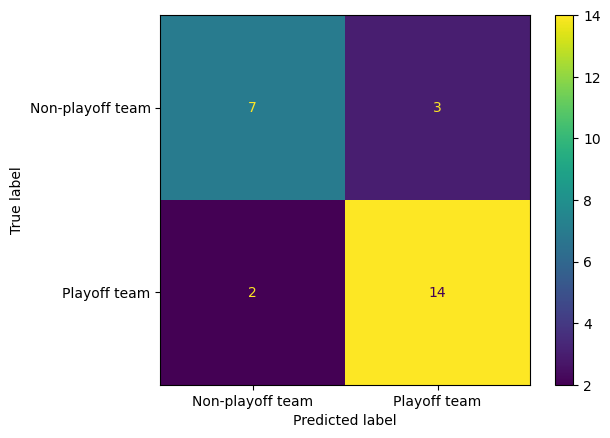

In [74]:
from sklearn.naive_bayes import GaussianNB

model=GaussianNB()

model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


y_pred=model.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print(accuracy)
print(f1)

cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-playoff team","Playoff team"])
disp.plot()



After training on the training data, I had the model predict whether the records in the test data were playoff teams based on their features. The accuracy and f1 scores were both around 80% which is pretty high and the confusion matrix shows that the model was equally proficient at predicting teams to make the playoffs as they are at predicting teams to miss the playoffs.

Further, I would like to test other subsets of features to find a more accurate model. And then carry out the same process to evaluate models based on regular 5 on 5 play and compare the accuracy of these two models.

For now, it is clear to see that player evaluation metrics during power plays can be used to predict regular season success.